# UFL Rule Impact Analysis — NFL 2025 Play-by-Play
> **Modeling assumption:** We are modeling rule impacts, not game theory responses. Assume teams behave exactly as they did historically.

In [1]:
# Cell 1 — Imports
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import nfl_data_py as nfl

pd.set_option('display.float_format', '{:.3f}'.format)
pd.set_option('display.max_columns', 20)
sns.set_theme(style='whitegrid', palette='muted')
%matplotlib inline

In [2]:
# Cell 2 — Load play-by-play data (regular season only)
pbp = nfl.import_pbp_data([2025], downcast=True)
pbp = pbp[pbp['season_type'] == 'REG']
print(f'Loaded {len(pbp):,} regular season plays')

2025 done.
Downcasting floats.
Loaded 46,452 regular season plays


In [3]:
# Cell 3 — Identify banned punts
#
# UFL rule: no punts allowed inside the opponent's 50-yard line.
# Exemption: rule does NOT apply inside the final 2 minutes of either half.
#   half_seconds_remaining <= 120 captures last 2 min before halftime
#   and last 2 min before end of game (column resets to 1800 each half).

punts           = pbp[pbp['play_type'] == 'punt']
punts_in_opp    = punts[punts['yardline_100'] < 50]
punts_exempt    = punts_in_opp[punts_in_opp['half_seconds_remaining'] <= 120]
banned_punts    = punts_in_opp[punts_in_opp['half_seconds_remaining'] > 120]

print(f'Total punts:              {len(punts):,}')
print(f'Punts in opp territory:   {len(punts_in_opp):,}')
print(f'Exempt (2-min window):    {len(punts_exempt):,}')
print(f'Banned punts:             {len(banned_punts):,}')

Total punts:              1,933
Punts in opp territory:   257
Exempt (2-min window):    31
Banned punts:             226


In [4]:
# Cell 4 — League-wide punt summary as a DataFrame

n_total   = len(punts)
n_opp     = len(punts_in_opp)
n_exempt  = len(punts_exempt)
n_banned  = len(banned_punts)

summary = pd.DataFrame({
    'Metric': [
        'Total punts',
        'Punts in opponent territory (yd_100 < 50)',
        'Exempt — inside 2-min warning',
        'Banned under UFL rule',
        '% of all punts that would be banned',
    ],
    'Value': [
        f'{n_total:,}',
        f'{n_opp:,}',
        f'{n_exempt:,}',
        f'{n_banned:,}',
        f'{n_banned / n_total * 100:.1f}%',
    ]
}).set_index('Metric')

summary

,Value
Metric,
Total punts,"1,933"
Punts in opponent territory (yd_100 < 50),257
Exempt — inside 2-min warning,31
Banned under UFL rule,226
% of all punts that would be banned,11.7%


In [5]:
# Cell 5 — Banned punts by score situation
#
# score_differential = possession team score minus opponent score.
# Trailing (1 score)   = down 1–8 pts (a TD + 2pt closes the gap)
# Trailing (2+ scores) = down 9+ pts

SITUATION_ORDER = ['Leading', 'Tied', 'Trailing (1 score)', 'Trailing (2+ scores)']

def score_situation(diff):
    if diff > 0:    return 'Leading'
    elif diff == 0: return 'Tied'
    elif diff >= -8: return 'Trailing (1 score)'
    else:           return 'Trailing (2+ scores)'

banned_scored = banned_punts.assign(
    situation=banned_punts['score_differential'].apply(score_situation)
)

situation_df = (
    banned_scored
    .groupby('situation')
    .agg(
        count      =('ydstogo', 'count'),
        avg_ydstogo=('ydstogo', 'mean'),
    )
    .reindex(SITUATION_ORDER)
    .assign(pct=lambda df: (df['count'] / n_banned * 100).round(1))
    [['count', 'pct', 'avg_ydstogo']]
)

situation_df.columns = ['Count', '% of Banned Punts', 'Avg Yards to Go']
situation_df['Avg Yards to Go'] = situation_df['Avg Yards to Go'].round(1)
situation_df

,Count,% of Banned Punts,Avg Yards to Go
situation,,,
Leading,96,42.500,8.700
Tied,49,21.700,9.800
Trailing (1 score),59,26.100,11.200
Trailing (2+ scores),22,9.700,11.600


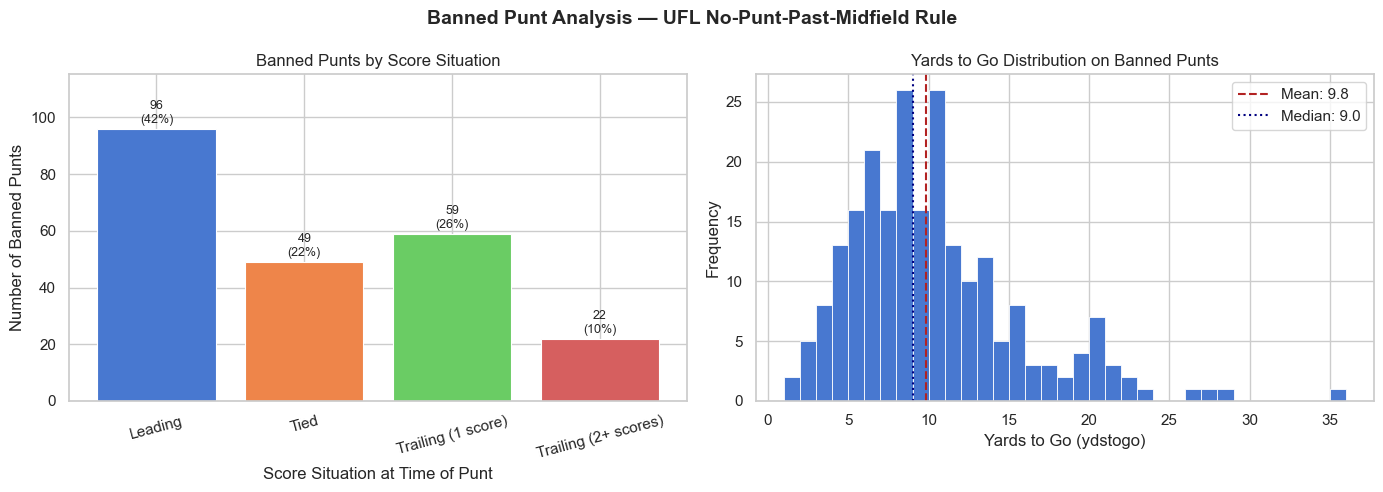

In [6]:
# Cell 6 — Visualizations

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Banned Punt Analysis — UFL No-Punt-Past-Midfield Rule', fontsize=14, fontweight='bold')

# ── Chart 1: Bar chart of banned punts by score situation ─────────────────────
ax1 = axes[0]
plot_data = situation_df['Count'].dropna()
colors = sns.color_palette('muted', len(plot_data))

bars = ax1.bar(plot_data.index, plot_data.values, color=colors, edgecolor='white', linewidth=0.8)

for bar, (_, row) in zip(bars, situation_df.dropna().iterrows()):
    ax1.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 1,
        f"{int(row['Count'])}\n({row['% of Banned Punts']:.0f}%)",
        ha='center', va='bottom', fontsize=9
    )

ax1.set_title('Banned Punts by Score Situation', fontsize=12)
ax1.set_xlabel('Score Situation at Time of Punt')
ax1.set_ylabel('Number of Banned Punts')
ax1.tick_params(axis='x', rotation=15)
ax1.set_ylim(0, plot_data.max() * 1.2)

# ── Chart 2: Histogram of ydstogo on banned punts ─────────────────────────────
ax2 = axes[1]
ydstogo_vals = banned_punts['ydstogo'].dropna()

ax2.hist(ydstogo_vals, bins=range(1, int(ydstogo_vals.max()) + 2),
         color=sns.color_palette('muted')[0], edgecolor='white', linewidth=0.6)

ax2.axvline(ydstogo_vals.mean(),   color='firebrick', linestyle='--', linewidth=1.5,
            label=f'Mean: {ydstogo_vals.mean():.1f}')
ax2.axvline(ydstogo_vals.median(), color='navy',      linestyle=':',  linewidth=1.5,
            label=f'Median: {ydstogo_vals.median():.1f}')

ax2.set_title('Yards to Go Distribution on Banned Punts', fontsize=12)
ax2.set_xlabel('Yards to Go (ydstogo)')
ax2.set_ylabel('Frequency')
ax2.legend()

plt.tight_layout()
plt.savefig('banned_punt_charts.png', dpi=150, bbox_inches='tight')
plt.show()

In [7]:
# Cell 7 — EPA swing table (go-for-it vs punt, by ydstogo bucket)
#
# Assumptions:
#   - Conversion rates derived from this season's 4th-down go-for-it plays
#     (play_type == run or pass on 4th down), bucketed by ydstogo.
#   - 'Converted' defined via fourth_down_converted == 1.
#   - Expected EPA of going for it = P(conv)*E[EPA|conv] + P(fail)*E[EPA|fail]
#   - EPA swing = E[EPA go-for-it] - avg punt EPA for that bucket.
#   - Modeling rule impact only; no adaptive strategy assumed.

BUCKET_LABELS = ['0–1', '2–3', '4–5', '6–10', '11+']
BUCKET_BINS   = [0, 1, 3, 5, 10, float('inf')]

fourth_go = pbp[
    (pbp['down'] == 4) &
    (pbp['play_type'].isin(['run', 'pass']))
].copy()

fourth_go['bucket'] = pd.cut(
    fourth_go['ydstogo'], bins=BUCKET_BINS,
    labels=BUCKET_LABELS, right=True, include_lowest=True
)

banned_bucketed = banned_punts.copy()
banned_bucketed['bucket'] = pd.cut(
    banned_bucketed['ydstogo'], bins=BUCKET_BINS,
    labels=BUCKET_LABELS, right=True, include_lowest=True
)

# Conversion stats per bucket
_attempts = (
    fourth_go.groupby('bucket', observed=True)['fourth_down_converted']
    .agg(go_attempts='count', conv_rate='mean')
)
_epa_conv = (
    fourth_go[fourth_go['fourth_down_converted'] == 1]
    .groupby('bucket', observed=True)['epa'].mean()
    .rename('epa_if_converted')
)
_epa_fail = (
    fourth_go[fourth_go['fourth_down_converted'] == 0]
    .groupby('bucket', observed=True)['epa'].mean()
    .rename('epa_if_failed')
)
_punt_epa = (
    banned_bucketed.groupby('bucket', observed=True)['epa'].mean()
    .rename('avg_punt_epa')
)

epa_table = (
    _attempts.join(_epa_conv).join(_epa_fail).join(_punt_epa)
    .reindex(BUCKET_LABELS)
)

epa_table['exp_epa_go'] = (
    epa_table['conv_rate'] * epa_table['epa_if_converted']
    + (1 - epa_table['conv_rate']) * epa_table['epa_if_failed']
)
epa_table['epa_swing'] = epa_table['exp_epa_go'] - epa_table['avg_punt_epa']

epa_display = epa_table[[
    'go_attempts', 'conv_rate', 'epa_if_converted',
    'epa_if_failed', 'exp_epa_go', 'avg_punt_epa', 'epa_swing'
]].copy()

epa_display.columns = [
    'Go Attempts', 'Conv Rate', 'EPA if Conv',
    'EPA if Failed', 'Exp EPA (Go)', 'Avg Punt EPA', 'EPA Swing'
]
epa_display['Conv Rate'] = epa_display['Conv Rate'].map('{:.1%}'.format)

epa_display.index.name = 'Yards to Go'
epa_display.style \
    .format('{:+.3f}', subset=['EPA if Conv', 'EPA if Failed', 'Exp EPA (Go)', 'Avg Punt EPA', 'EPA Swing']) \
    .background_gradient(subset=['EPA Swing'], cmap='RdYlGn', vmin=-1, vmax=1) \
    .set_caption('EPA Swing: positive = going for it is the higher-EPA decision')

,Go Attempts,Conv Rate,EPA if Conv,EPA if Failed,Exp EPA (Go),Avg Punt EPA,EPA Swing
Yards to Go,,,,,,,
0–1,360,65.8%,+2.236,-3.670,+0.218,-0.956,+1.174
2–3,225,59.1%,+3.235,-2.955,+0.704,-0.662,+1.366
4–5,123,56.1%,+3.239,-2.673,+0.643,-0.416,+1.059
6–10,119,30.3%,+3.297,-2.454,-0.714,-0.305,-0.409
11+,55,25.5%,+3.444,-1.852,-0.504,-0.034,-0.470
